In [1]:
%matplotlib inline

import os
import glob
import numpy as np
from numpy.fft import fft, ifft, fftfreq
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import gridspec
from matplotlib.animation import FuncAnimation
import seaborn as sns
from nltools.data import Brain_Data, Adjacency
from nltools.mask import expand_mask, roi_to_brain
from nltools.stats import isc, isfc, isps, fdr, threshold, phase_randomize, circle_shift, _butter_bandpass_filter, _phase_mean_angle, _phase_vector_length
from nilearn.plotting import view_img_on_surf, view_img
from sklearn.metrics import pairwise_distances
from sklearn.utils import check_random_state
from scipy.stats import ttest_1samp
from scipy.signal import hilbert
import networkx as nx
from IPython.display import HTML

# import nest_asyncio
# nest_asyncio.apply()
import datalad.api as dl

/Users/orenkobo/Desktop/PhD_new/repos/HebLingStudy/venv_3.8/lib/python3.8/site-packages/nilearn/datasets/__init__.py:86: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  warn("Fetchers from the nilearn.datasets module will be "


In [2]:
vodka_scrambled_subject_ids =["088", "115", "116", "117", "118", "119", "120", "121", "122",
                              "123", "124", "125", "126", "127", "128", "129", "130", "131"]
scrambled_fmri_data_path   = "/Users/orenkobo/Desktop/PhD/Aim2_new/Materials/vodka/deriviatives_new/deriviatives/fmriprep"

vodka_intact_subject_ids = ["023", "030", "032", "038", "052", "079", "086", "087", "088",
                              "089", "090", "097", "098", "102", "103", "107", "109", "110"]
intact_fmri_data_path   = "/Users/orenkobo/Desktop/PhD/Aim3/narratives/data/narratives/derivatives/fmriprep/"
nii_desc = "space-MNI152NLin2009cAsym_res-native_desc-preproc_bold"

In [3]:

def create_func_fns(subject_ids, task, data_path):
    func_fns = []
    regressor_fns = []
    for subj_id in subject_ids:
        subj_func_dir = '{}/sub-{}/'.format(data_path,subj_id)
        subj_func_file = '{}/func/sub-{}_task-{}_{}.nii.gz'.format(subj_func_dir, subj_id, task,  nii_desc)
        regressor_file = f'{subj_func_dir}/func/sub-{subj_id}_task-{task}_desc-confounds_regressors.tsv'
        func_fns.append(subj_func_file)
        regressor_fns.append(regressor_file)
    print("\n".join(regressor_fns))
    print("------")
    print("\n".join(func_fns))
    print("------")
    print('Loading data from {0} subjects...'.format(len(func_fns)))
    return func_fns, regressor_fns

intact_func_fns, intact_regressor_fns = create_func_fns(vodka_intact_subject_ids, "milky", intact_fmri_data_path)
scrambled_func_fns, scrambled_regressor_fns = create_func_fns(vodka_scrambled_subject_ids, "vodkascram", scrambled_fmri_data_path)

/Users/orenkobo/Desktop/PhD/Aim3/narratives/data/narratives/derivatives/fmriprep//sub-023//func/sub-023_task-milky_desc-confounds_regressors.tsv
/Users/orenkobo/Desktop/PhD/Aim3/narratives/data/narratives/derivatives/fmriprep//sub-030//func/sub-030_task-milky_desc-confounds_regressors.tsv
/Users/orenkobo/Desktop/PhD/Aim3/narratives/data/narratives/derivatives/fmriprep//sub-032//func/sub-032_task-milky_desc-confounds_regressors.tsv
/Users/orenkobo/Desktop/PhD/Aim3/narratives/data/narratives/derivatives/fmriprep//sub-038//func/sub-038_task-milky_desc-confounds_regressors.tsv
/Users/orenkobo/Desktop/PhD/Aim3/narratives/data/narratives/derivatives/fmriprep//sub-052//func/sub-052_task-milky_desc-confounds_regressors.tsv
/Users/orenkobo/Desktop/PhD/Aim3/narratives/data/narratives/derivatives/fmriprep//sub-079//func/sub-079_task-milky_desc-confounds_regressors.tsv
/Users/orenkobo/Desktop/PhD/Aim3/narratives/data/narratives/derivatives/fmriprep//sub-086//func/sub-086_task-milky_desc-confounds_

50


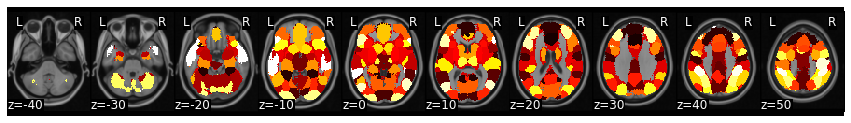

In [4]:
mask = Brain_Data('http://neurovault.org/media/images/2099/Neurosynth%20Parcellation_0.nii.gz')
mask_x = expand_mask(mask)
print(len(mask_x))
mask.plot()

In [5]:
import datetime, joblib

def get_reg_df(reg_csv):
    confounds_df = pd.read_csv(reg_csv, delimiter='\t', index_col=False)
    confounds_cols = ['framewise_displacement']

    if pd.isna(confounds_df['framewise_displacement'].iloc[0]):
        confounds_df['framewise_displacement'].iloc[0] = 0

    confounds_arr = confounds_df[confounds_cols]
    return confounds_arr

def generate_roi_df(regressor_fns, func_fns, out_dir, TR=2):
    sub_data = {}
    for i, f in enumerate(func_fns):

        reg_arr = get_reg_df(regressor_fns[i])
        subj_id = os.path.basename(f).split('_')[0]
        print(f"{datetime.datetime.now()} : {subj_id} ({i} / {len(func_fns)}")
        bdata = Brain_Data(f)

        p_data, d, s = bdata.filter(high_pass=0.007, sampling_freq=1/TR, detrend = True, standardize = True,
                             confounds = reg_arr)
        p_data = p_data.smooth(fwhm=6)

        roi = p_data.extract_roi(mask)

        df_mean_per_roi = pd.DataFrame(roi.T)#.to_csv(os.path.join(os.path.dirname(f), f"{sub}_{scan}_Average_ROI_n50.csv" ), index=False)
        if subj_id in ["105","123","038"]:
            df_mean_per_roi = df_mean_per_roi.iloc[10:279].reset_index(drop=True)
        else:
            df_mean_per_roi = df_mean_per_roi.iloc[14:283].reset_index(drop=True)

        sub_data[subj_id] = df_mean_per_roi
        df_mean_per_roi.to_csv(f"{out_dir}/{subj_id}_Average_ROI_n50.csv" , index=False )

    joblib.dump(sub_data, f"{out_dir}sub_data_dct_2.jbl")
    print("Done")
    return df_mean_per_roi, sub_data

def subdata_from_csv(cond, sub_ids):
    dir_name = f"/Users/orenkobo/Desktop/PhD/Aim3/narratives/artifacts/connectivity_artifacts/{cond}/"
    sub_timeseries = {}
    for sub_id in sub_ids:
        roi_df = pd.read_csv(f"{dir_name}/sub-{sub_id}_Average_ROI_n50.csv")#.reset_index(inplace=True, drop=True)
        sub_timeseries[sub_id] = roi_df
    return sub_timeseries

In [6]:
new_subdata = False
if new_subdata:
    intact_df, intact_sub_data = generate_roi_df(intact_regressor_fns, intact_func_fns,
                                out_dir="/Users/orenkobo/Desktop/PhD/Aim3/narratives/artifacts/connectivity_artifacts/intact/")

    scrambled_df, scrambled_sub_data = generate_roi_df(scrambled_regressor_fns, scrambled_func_fns,
                                                       out_dir="/Users/orenkobo/Desktop/PhD/Aim3/narratives/artifacts/connectivity_artifacts/scrambled/")
else:
    intact_subdata    = subdata_from_csv("intact", vodka_intact_subject_ids)
    scrambled_subdata = subdata_from_csv("scrambled", vodka_scrambled_subject_ids)


In [7]:
roi_rows = []
orig_rois_df = pd.read_csv('https://raw.githubusercontent.com/naturalistic-data-analysis/tutorial_development/master/hypertools/rois.csv', header=None, names=['ID', 'Region'])

for r in range(50):
    qd = orig_rois_df[orig_rois_df.ID == r]
    if len(qd) > 0:
        row = [r, qd.Region.iloc[0]]
    else:
        row = [r, "UND"]
    roi_rows.append(row)

rois_df = pd.DataFrame(roi_rows, columns = ["ID", "Region"])
rois_df

ID                                             Region
0    0                                      Anterior MPFC
1    1                           Fusiform/parahippocampus
2    2                                              DMPFC
3    3                     Sensorimotor/postcentral gyrus
4    4                                                 V1
5    5         TPJ posterior supra marginal/angular gyrus
6    6                                      PCC/precuneus
7    7                                           Thalamus
8    8                                                SMA
9    9                                   Precentral gyrus
10  10                                    Cerebellum (VI)
11  11                        Temporal occipital fusiform
12  12                                           Amygdala
13  13                            Superior temporal gyrus
14  14                                       White matter
15  15  TPJ anterior supra marginal gyrus/parietal ope...
16  16                                         Mid insula
17  17                                            Putamen
18  18                             Dorsal anterior insula
19  19                                   PCC/superior LOC
20  20          Lateral occipital/temporal occipital (V2)
21  21                                                UND
22  22                                               DACC
23  23              Anterior fronto-parietal (DLPFC/DACC)
24  24                              Intercalcarine cortex
25  25                                     Anterior VLPFC
26  26                                         Left motor
27  27                                           Left IFG
28  28                                        Hippocampus
29  29                                     Dorsal caudate
30  30                                                UND
31  31                                                UND
32  32                                              VMPFC
33  33                                                UND
34  34                                               NACC
35  35                                                 A1
36  36                                                UND
37  37                            Ventral anterior insula
38  38                                                UND
39  39                                       Superior LOC
40  40                                                UND
41  41                                                UND
42  42                                  Cerebellum (crus)
43  43                                                UND
44  44                                              DLPFC
45  45                                    Right IFG VLPFC
46  46                                       Inferior LOC
47  47                                        Right motor
48  48                                      Somatosensory
49  49                                                STS

In [8]:
def get_subject_roi(data, roi):
    sub_rois = {}
    for sub in data:
        sub_rois[sub] = data[sub].iloc[:, roi]
    return pd.DataFrame(sub_rois)

def bootstrap_subject_matrix(similarity_matrix, random_state=None):
    '''This function shuffles subjects within a similarity matrix based on recommendation by Chen et al., 2016'''

    random_state = check_random_state(random_state)
    n_sub = similarity_matrix.shape[0]
    bootstrap_subject = sorted(random_state.choice(np.arange(n_sub), size=n_sub, replace=True))
    return similarity_matrix[bootstrap_subject, :][:, bootstrap_subject]



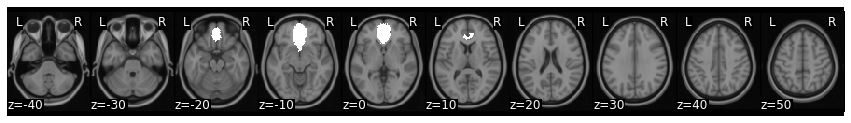

In [9]:
roi = 32

mask_x[roi].plot()

i_sub_rois = get_subject_roi(intact_subdata, roi)
s_sub_rois = get_subject_roi(scrambled_subdata, roi)

In [10]:
i_sub_rois.shape

(269, 18)

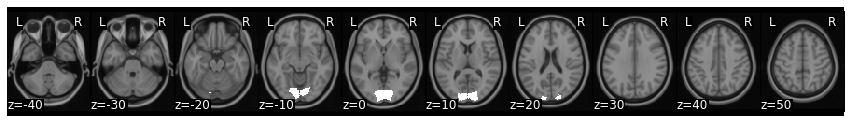

In [386]:
v1_roi = 4

mask_x[v1_roi].plot()

v1_i_sub_rois = get_subject_roi(intact_subdata, v1_roi)
v1_s_sub_rois = get_subject_roi(scrambled_subdata, v1_roi)

In [500]:
get_subject_roi(scrambled_subdata, v1_roi)

088       115       116       117       118       119       120  \
0    0.073841  0.055103 -0.626839  0.504733 -0.326077 -0.227356 -0.335293   
1    0.374030  0.012927 -0.725334  0.571719 -0.171711 -0.429449  0.251476   
2    0.225440  0.180730 -0.602925  0.037479  0.126911 -0.554802  0.267441   
3   -0.145870  0.299832 -0.259637 -0.165460 -0.194334 -0.442236  0.395472   
4   -0.200974  0.404374 -0.112206 -0.579526  0.424596 -0.375393  0.462910   
..        ...       ...       ...       ...       ...       ...       ...   
264 -0.056378  0.530503 -0.194199 -0.383960  0.954582  0.167905  0.337536   
265 -0.540447  0.708290 -0.293386 -0.151873  0.803708  0.239323  0.437005   
266 -0.491628  0.330492 -0.053959 -0.203744  0.368846  0.294842  0.346023   
267 -0.322521 -0.274511  0.244890 -0.010836 -0.100744  0.205543  0.018915   
268  0.016258 -0.666010  0.364636 -0.177067 -0.678070 -0.026396 -0.226639   

          121       122       123       124       125       126       127  \
0   -0.510493 -0.824398  0.193481 -0.626576 -0.254737 -0.410535 -0.885891   
1   -0.826089  0.656115  0.229680 -0.617831 -0.226629 -0.921676 -0.693884   
2   -0.267564  0.099388  0.332429 -0.450335  0.303041 -1.038063 -0.593174   
3    0.449983  0.009249  0.171799 -0.318877  0.057706 -1.039705 -0.322522   
4    0.169171 -0.082653  0.203059 -0.142882  0.069075 -0.905019 -0.189295   
..        ...       ...       ...       ...       ...       ...       ...   
264  0.126087 -0.030217 -0.271290 -0.475013 -0.625376  0.543080  0.234033   
265  0.191841 -0.105967 -0.414491 -0.467936 -0.101884  0.646992  0.272456   
266  0.097648  0.104705 -0.329797 -0.162994 -0.144094  0.436910  0.684288   
267  0.056737  0.138076 -0.303800  0.231785 -0.385345  0.204714  0.362656   
268  0.240181  0.456677 -0.042471  0.502976 -0.083225  0.089033 -0.088504   

          128       129       130       131  
0   -0.307067  0.219900 -0.468248  0.484844  
1   -0.380620  0.234947 -0.129859  0.261266  
2   -0.458191  0.431588 -0.154996  0.165185  
3   -0.336444  0.455551 -0.113491  0.244862  
4   -0.216656  0.188810 -0.199956  0.194464  
..        ...       ...       ...       ...  
264  0.247157  0.034844  0.253171 -0.460666  
265  0.367369 -0.102469 -0.588902 -0.097674  
266  0.327667  0.166227 -0.948337 -0.273259  
267  0.388930  0.283560 -1.103108 -0.326925  
268  0.546066  0.132691 -0.915843 -0.381281  

[269 rows x 18 columns]

In [497]:
import datetime
print(datetime.datetime.now())
i_isc_r_brain, isc_p_brain = isc_wholebrain(intact_subdata)
# i_isc_r_brain.plot(cmap='RdBu_r')
print(datetime.datetime.now())



2022-02-08 08:55:37.239787
ROI 0 got -0.002901777161254948
ROI 1 got -0.002392268486902882
ROI 2 got -0.002987039579530726
ROI 3 got -0.0023628808357391007


KeyboardInterrupt: 

In [487]:
i_isc_r_brain

NameError: name 'i_isc_r_brain' is not defined

2022-02-06 10:39:42.326720
nltools.data.brain_data.Brain_Data(data=(238955,), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[]) nltools.data.brain_data.Brain_Data(data=(238955,), Y=0, X=(0, 0), mask=MNI152_T1_2mm_brain_mask.nii.gz, output_file=[])
2022-02-06 10:40:29.828324


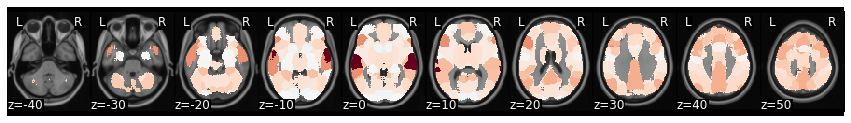

In [71]:
import datetime
print(datetime.datetime.now())
s_isc_r_brain, s_isc_p_brain = isc_wholebrain(scrambled_subdata)
s_isc_r_brain.plot(cmap='RdBu_r')
print(datetime.datetime.now())



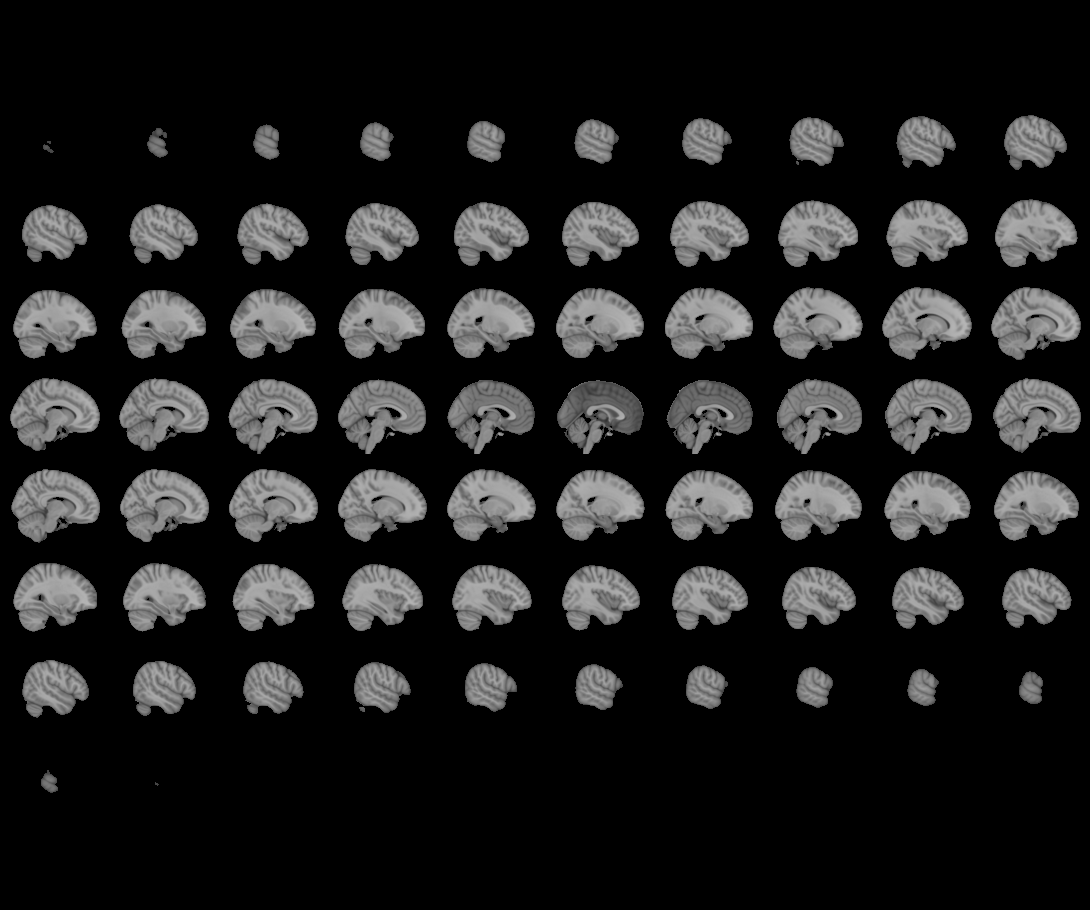
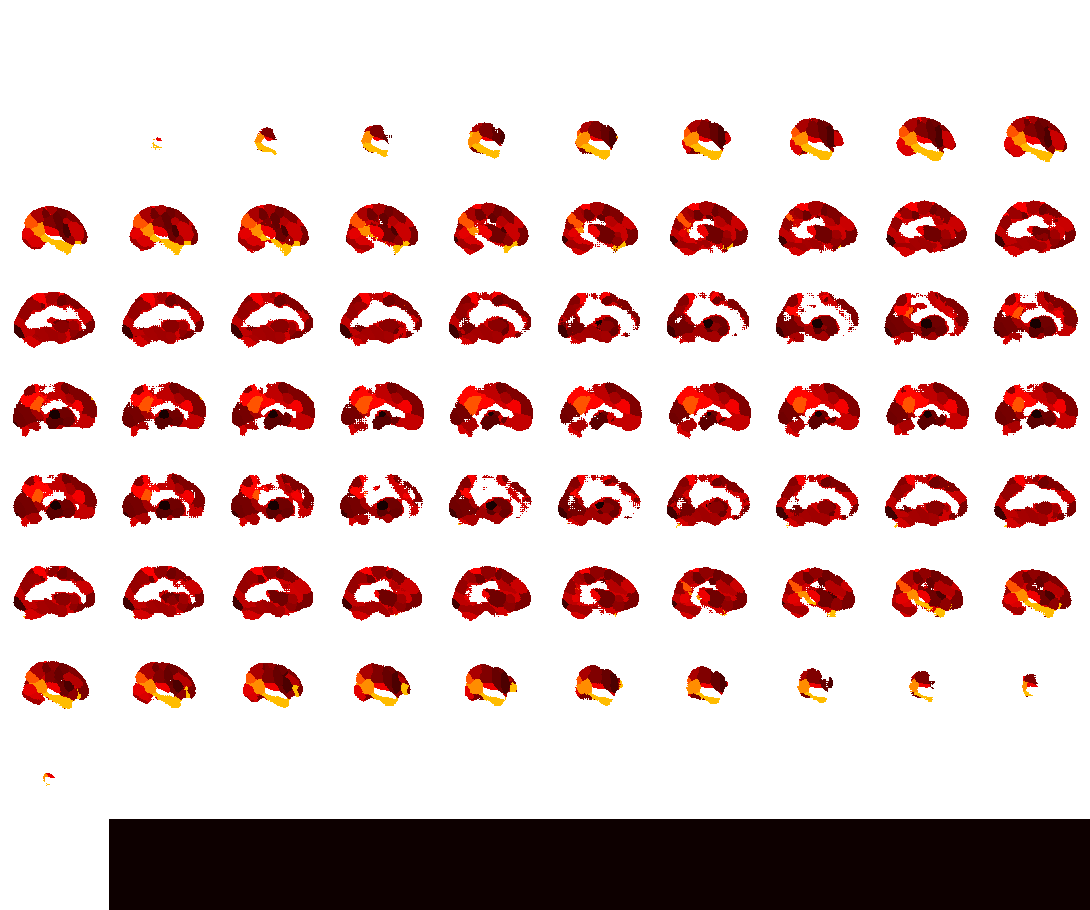

In [72]:
view_img(i_isc_r_brain.to_nifti())

In [73]:
view_img_on_surf(threshold(isc_r_brain, isc_p_brain, thr=.001).to_nifti())

In [78]:
i_sub_rois

023       030       032       038       052       079       086  \
0   -0.125485 -0.078430 -0.439079  0.008248  0.111229 -0.123699 -0.358492   
1   -0.032519 -0.171497 -0.330956  0.145892 -0.266411  0.093597 -0.278931   
2   -0.211838 -0.267082  0.101410  0.219401 -0.217850 -0.026019 -0.273728   
3   -0.187857 -0.431130 -0.505133  0.206378 -0.206219 -0.308420  0.099237   
4   -0.040707 -0.222649 -0.777669  0.148052 -0.660015 -0.050753  0.070873   
..        ...       ...       ...       ...       ...       ...       ...   
264  0.215299  0.129983  0.159094  0.205740  0.022270 -0.082173  0.016414   
265  0.367629  0.067103  0.086580  0.110159  0.102617 -0.049985 -0.071785   
266  0.184613  0.077021  0.200357 -0.092144  0.298677  0.077953 -0.032845   
267 -0.114338  0.107818  0.374305 -0.192318 -0.045948 -0.227962  0.090223   
268 -0.184733  0.058604  0.155442 -0.221537 -0.054404  0.107585  0.184210   

          087       088       089       090       097       098       102  \
0   -0.338356 -0.203586 -0.519897 -0.241334 -0.209710 -0.191221  0.286229   
1   -0.431256 -0.111609 -0.516896 -0.185383 -0.144412 -0.331348  0.274930   
2   -0.451102 -0.258042 -0.399822 -0.228835 -0.186352  0.117982  0.077082   
3   -0.317224 -0.129351 -0.299948 -0.373328 -0.075064  0.137378  0.074233   
4   -0.225058 -0.122427 -0.353792 -0.439060 -0.110880 -0.075569  0.135991   
..        ...       ...       ...       ...       ...       ...       ...   
264  0.113138 -0.048787 -0.058983  0.419879 -0.321668  0.109717 -0.240190   
265  0.077673  0.232330  0.038220  0.061747 -0.262621  0.056524 -0.348194   
266  0.039911  0.159894  0.264248  0.297486 -0.105824 -0.041408  0.042760   
267  0.089419 -0.022473  0.153728  0.168225  0.063812  0.021461  0.156116   
268  0.210528 -0.212163  0.058591  0.413703  0.272472  0.376045 -0.003555   

          103       107       109       110  
0   -0.942685 -0.089834 -0.126255  0.014254  
1   -0.959037 -0.002468 -0.170259 -0.111858  
2   -0.657106  0.004966 -0.274317  0.084226  
3   -0.489333 -0.174601  0.015580 -0.131611  
4   -0.378468 -0.173147  0.146998 -0.166125  
..        ...       ...       ...       ...  
264  0.296268  0.058302 -0.095578  0.139343  
265 -0.014475  0.396613  0.148375 -0.062188  
266  0.041045  0.163360  0.126636 -0.041887  
267  0.132273  0.336855  0.225483 -0.012750  
268  0.368942  0.319320  0.376861 -0.036395  

[269 rows x 18 columns]

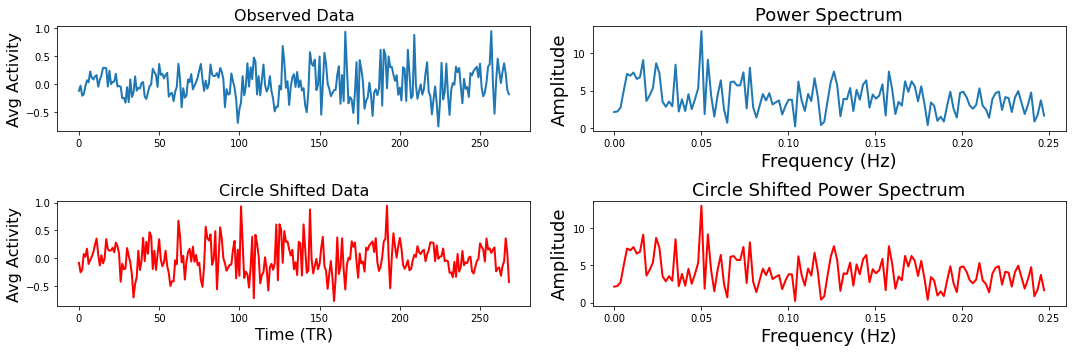

In [79]:
sub = '023'
sampling_freq = .5

f,a = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))
a[0,0].plot(i_sub_rois[sub], linewidth=2)
a[0,0].set_ylabel('Avg Activity', fontsize=16)
a[0,1].set_xlabel('Time (TR)', fontsize=18)
a[0,0].set_title('Observed Data', fontsize=16)

fft_data = fft(i_sub_rois[sub])
freq = fftfreq(len(fft_data), 1/sampling_freq)
n_freq = int(np.floor(len(fft_data)/2))
a[0,1].plot(freq[:n_freq], np.abs(fft_data)[:n_freq], linewidth=2)
a[0,1].set_xlabel('Frequency (Hz)', fontsize=18)
a[0,1].set_ylabel('Amplitude', fontsize=18)
a[0,1].set_title('Power Spectrum', fontsize=18)

circle_shift_data = circle_shift(i_sub_rois[sub])
a[1,0].plot(circle_shift_data, linewidth=2, color='red')
a[1,0].set_ylabel('Avg Activity', fontsize=16)
a[1,0].set_xlabel('Time (TR)', fontsize=16)
a[1,0].set_title('Circle Shifted Data', fontsize=16)

fft_circle = fft(circle_shift_data)
a[1,1].plot(freq[:n_freq], np.abs(fft_circle)[:n_freq], linewidth=2, color='red')
a[1,1].set_xlabel('Frequency (Hz)', fontsize=18)
a[1,1].set_ylabel('Amplitude', fontsize=18)
a[1,1].set_title('Circle Shifted Power Spectrum', fontsize=18)

plt.tight_layout()

In [447]:
from brainiak.isc import isc as bri_isc

In [479]:
qq = list(intact_subdata.items())
qqs = list(scrambled_subdata.items())

In [480]:
qqq = [x[1] for x in qq]
qqqs = [x[1] for x in qqs]

In [481]:
qqqq = np.array(qqq)
qqqqs = np.array(qqqs)

In [482]:
lq = qqqq.reshape(269,50,18)
lqs = qqqqs.reshape(269,50,18)
lqs.shape

(269, 50, 18)

In [478]:
bri_isc(lq, pairwise=True)[:,32].mean()

0.5003350136853677

In [486]:
bri_isc(lqs, pairwise=False).mean()

0.7123448807059003

In [448]:
l_i = []
l_s = []
for roi in range(50):
    # c_i_sub_rois = get_subject_roi(intact_subdata, roi)
    # c_s_sub_rois = get_subject_roi(scrambled_subdata, roi)
    # c_i = bri_isc(c_i_sub_rois)
    # c_s = bri_isc(c_s_sub_rois)
    l_i.append(c_i['isc'])
    l_s.append(c_s['isc'])

ValueError: not enough values to unpack (expected 3, got 2)

<AxesSubplot:>

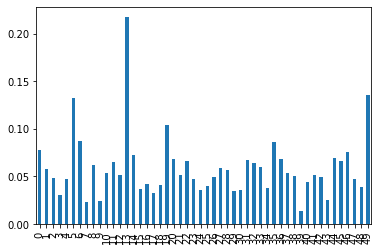

In [446]:
pd.Series(l_i).plot.bar()

/Users/orenkobo/Desktop/PhD_new/repos/HebLingStudy/venv_3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/orenkobo/Desktop/PhD_new/repos/HebLingStudy/venv_3.8/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

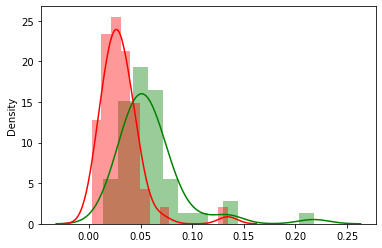

In [443]:
sns.distplot(l_i, color='green')
sns.distplot(l_s, color='red')

In [81]:
print(datetime.datetime.now())
stats_phase = isc(i_sub_rois, method='phase_randomize', n_bootstraps=5000, return_bootstraps=True)
print(datetime.datetime.now())
print(f"ISC: {stats_phase['isc']:.02}, p = {stats_phase['p']:.03}")

2022-02-06 10:45:01.343791
2022-02-06 10:45:08.012016
ISC: 0.061, p = 0.0002


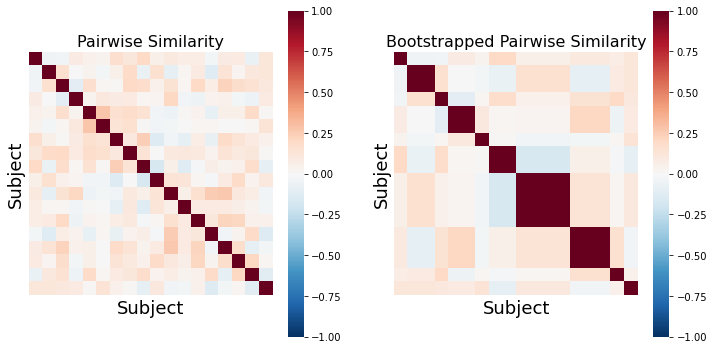

In [87]:
isc_analyze_roi(i_sub_rois)

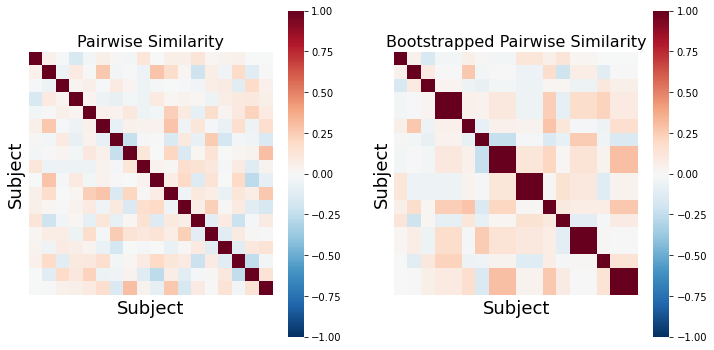

In [88]:
isc_analyze_roi(s_sub_rois)

In [395]:

def draw_null(sub_rois, t):
    stats_boot = isc(sub_rois, method='bootstrap', n_bootstraps=5000, return_bootstraps=True)
    stats_circle = isc(sub_rois, method='circle_shift', n_bootstraps=5000, return_bootstraps=True)
    # stats_phase = isc(i_sub_rois, method='phase_randomize', n_bootstraps=5000, return_bootstraps=True)
    # print(datetime.datetime.now())
    # print(f"ISC: {stats_phase['isc']:.02}, p = {stats_phase['p']:.03}")
    print(f"boost ISC: {stats_boot['isc']:.02}, p = {stats_boot['p']:.03}")
    print(f"circle shift  ISC: {stats_circle['isc']:.02}, p = {stats_circle['p']:.03}")
    # print(f"phase shift  ISC: {stats_phase['isc']:.02}, p = {stats_phase['p']:.03}")


    plt.figure(figsize=(12,6))
    sns.histplot(stats_boot['null_distribution'] - stats_boot['isc'], kde=True, label='Bootstrap' , color='purple')
    sns.histplot(stats_circle['null_distribution'], kde=True, label='Bootstrap', color='green')
    # if plot_circle:

    # sns.histplot(stats_phase['null_distribution'], kde=True, label='Bootstrap', color='blue')
    plt.ylabel('Frequency', fontsize=18)
    plt.xlabel('ISC Values (correlation)', fontsize=18)
    plt.title('ISC Null Distribution ' + t, fontsize=20)
    plt.axvline(stats_boot['isc'], linestyle='-', color='red', linewidth=4)
    lg = ['Observed ISC', 'Bootstrap Null']
    # if plot_circle:
    #     lg.append('Circle Shift Null')
    plt.legend(lg, fontsize=18)

    plt.axvline(stats_boot['ci'][0] - stats_boot['isc'], linestyle='--', color='blue')
    plt.axvline(stats_boot['ci'][1] - stats_boot['isc'], linestyle='--', color='blue')
    # if plot_circle:
    #     plt.axvline(stats_circle['ci'][0], linestyle='--', color='orange')
    #     plt.axvline(stats_circle['ci'][1], linestyle='--', color='orange')

    # plt.axvline(stats_phase['ci'][0], linestyle='--', color='green')
    # plt.axvline(stats_phase['ci'][1], linestyle='--', color='green')
    plt.show()

def compare_null(i_sub_rois , s_sub_rois, t):
    plt.figure(figsize=(12,6))
    i_stats_boot = isc(i_sub_rois, method='bootstrap', n_bootstraps=10000, return_bootstraps=True)
    # i_stats_circle = isc(i_sub_rois, method='circle_shift', n_bootstraps=10000, return_bootstraps=True)
    s_stats_boot = isc(s_sub_rois, method='bootstrap', n_bootstraps=10000, return_bootstraps=True)
    # s_stats_circle = isc(s_sub_rois, method='circle_shift', n_bootstraps=10000, return_bootstraps=True)

    # sns.histplot(i_stats_circle['null_distribution'], kde=True, label='i Bootstrap', color='green')
    sns.histplot(s_stats_boot['null_distribution'] - s_stats_boot['isc'], kde=True, label='s Bootstrap', color='blue')

    plt.axvline(i_stats_boot['isc'], linestyle='-', color='red', linewidth=2, label = 'i actual')
    plt.axvline(s_stats_boot['isc'], linestyle='-', color='red', linewidth=2, label = 's actual')
    lg = ['subject-wise Bootstrapping']
    # lg = ['Circle shift Randomization', 'subject-wise Bootstrapping']
    plt.text(i_stats_boot['isc'],800,f"intact isc \np boot={i_stats_boot['p']:.05}")
    plt.text(s_stats_boot['isc'],800,f"scrambled isc \np boot={s_stats_boot['p']:.03}")
    # plt.text(i_stats_boot['isc'],800,f"intact isc \np boot={i_stats_boot['p']:.03} \np circle ={i_stats_circle['p']:.05}",rotation=0)
    # plt.text(s_stats_boot['isc'],800,f"scrambled isc \np boot={s_stats_boot['p']:.03}\np circle ={s_stats_circle['p']:.05}",rotation=0)
    plt.title(f"{t} ISC - actual vs randomization (10000 iters)")
    plt.legend(lg)
    # plt.xlim([min(s_stats_boot['null_distribution'] - s_stats_boot['isc'] - 0.001),
    #           max(s_stats_boot['null_distribution'] - s_stats_boot['isc'] + 0.001)])
    plt.show()

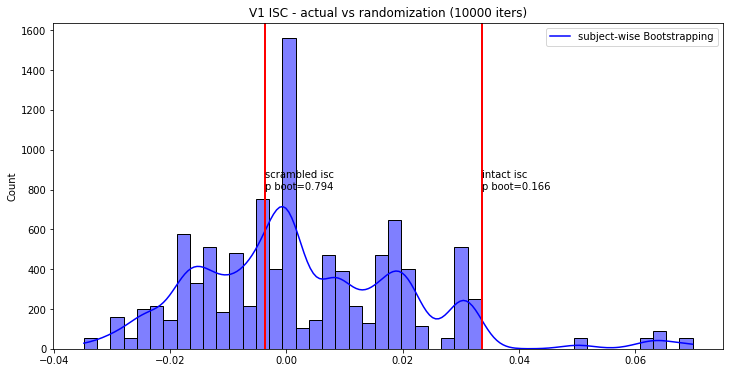

In [393]:

compare_null(v1_i_sub_rois, v1_s_sub_rois, "V1")

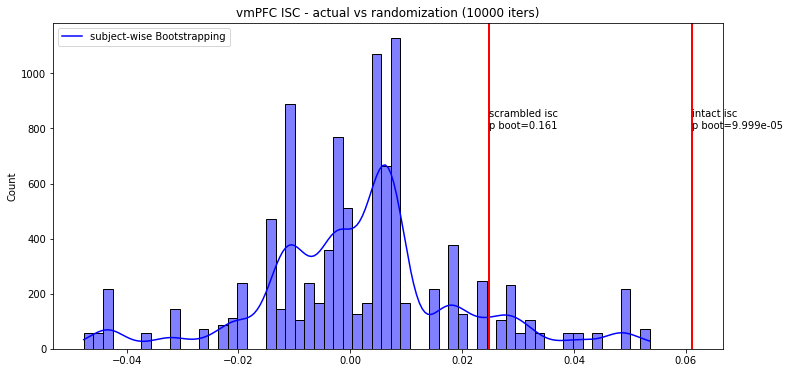

In [396]:
compare_null(i_sub_rois, s_sub_rois, "vmPFC")

boost ISC: 0.061, p = 0.0002
circle shift  ISC: 0.061, p = 0.0002


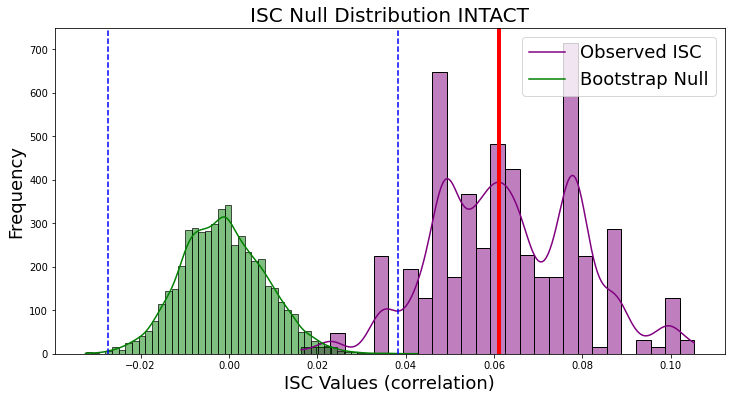

boost ISC: 0.025, p = 0.136
circle shift  ISC: 0.025, p = 0.0274


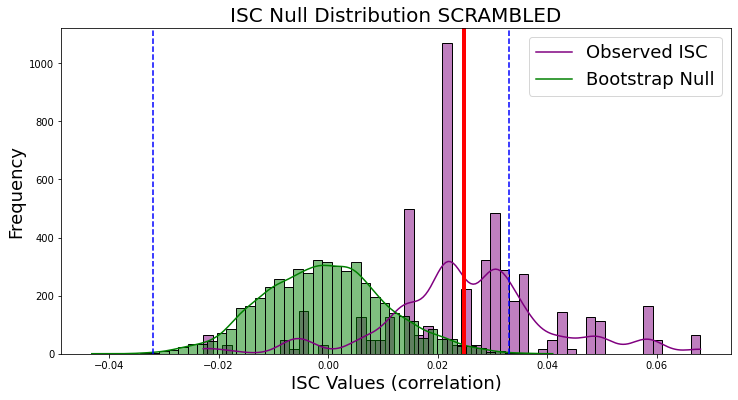

In [337]:
# print(datetime.datetime.now())

draw_null(i_sub_rois, "INTACT")
draw_null(s_sub_rois, "SCRAMBLED")

# print(datetime.datetime.now())

boost ISC: 0.061, p = 0.0002
circle shift  ISC: 0.061, p = 0.0002


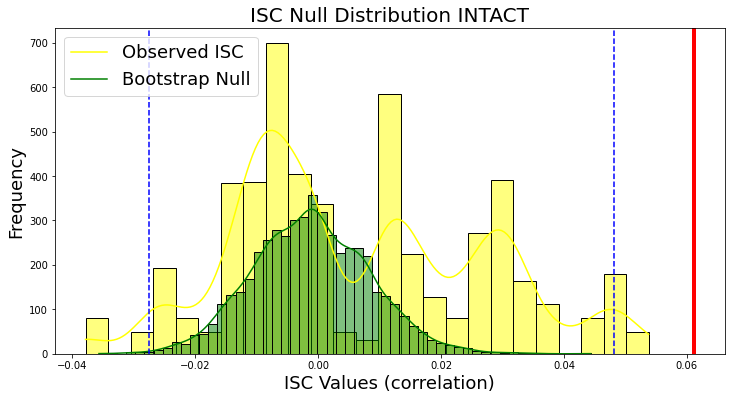

boost ISC: 0.025, p = 0.234
circle shift  ISC: 0.025, p = 0.0264


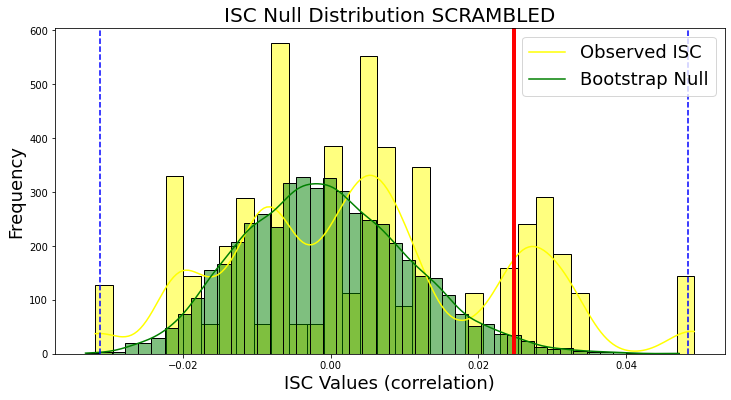

In [321]:
# draw_null(i_sub_rois, "INTACT", plot_circle = False)
# draw_null(s_sub_rois, "SCRAMBLED" , plot_circle = False)


In [424]:
def run_isfc(sub_timeseries, t):
    data = list(sub_timeseries.values())

    isfc_output = isfc(data)
    from matplotlib.patches import Rectangle

    f,a = plt.subplots(ncols=2, figsize=(18, 12))
    f.suptitle("ISFC " + t, fontsize = 24)
    f.subplots_adjust(top=0.88)
    sns.heatmap(np.array(isfc_output).mean(axis=0), vmin=-.1, vmax=0.45, square=True, cmap='RdBu_r',  center = 0,
                xticklabels=True, yticklabels=True,
                ax = a[0])

    a[0].add_patch(Rectangle((32, 0), 1, 50, fill=False, edgecolor='yellow', lw=4, clip_on=False))
    a[0].add_patch(Rectangle((4, 0), 1, 50, fill=False, edgecolor='green', lw=4, clip_on=False))
    # plt.title('Average ISFC', fontsize=20)
    plt.xlabel('ROI', fontsize=18)
    plt.ylabel('ROI', fontsize=18)
    # plt.show()
    a[0].legend(["vmPFC", "V1"], bbox_to_anchor=(1.0, 1.15))
    a[0].title.set_text("ISFC " + t)
    t, p = ttest_1samp(np.array([x.reshape(-1) for x in isfc_output]), 0)
    thresh = fdr(p, .00001)
    thresholded_t_pos = t.copy()
    thresholded_t_pos[p > thresh] = 0
    thresholded_t_pos[thresholded_t_pos <= 0] = 0
    thresholded_t_pos[thresholded_t_pos > 0] = 1
    thresholded_t_pos = np.reshape(thresholded_t_pos, isfc_output[0].shape)

    sns.heatmap(thresholded_t_pos, square=True, center = 0, xticklabels=True, yticklabels=True , ax = a[1])
    # plt.title('Positive ISFC Edges', fontsize=20)
    plt.xlabel('ROI', fontsize=18)
    plt.ylabel('ROI', fontsize=18)

    plt.show()
    #
    # synchrony = {}
    # tr = 2
    # for roi in range(50):
    #     stats = isps(get_subject_roi(sub_timeseries, roi), low_cut=0.01, high_cut=0.027, sampling_freq=1/tr)
    #     synchrony[roi] = stats['vector_length']
    # synchrony = pd.DataFrame(synchrony)
    #
    # sync = Adjacency(1 - pairwise_distances(synchrony.T, metric='correlation'), matrix_type='similarity')
    #
    # f,a = plt.subplots(ncols=2, figsize=(12, 6))
    #
    # sync.plot(vmin=-1, vmax=1, cmap='RdBu_r', axes=a[0], cbar=True)
    # sync.threshold(upper = .05, lower=0, binarize=True).plot(axes=a[1], cbar=True)
    # a[0].set_title('ISPS Functional Connectivity Matrix', fontsize=18)
    # a[1].set_title('Thresholded ISPS Functional Connectivity Matrix', fontsize=18)
    # plt.tight_layout()
    # plt.show()
    # i_sync.squareform()[32].mean()
    # s_sync.squareform()
    return isfc_output, thresholded_t_pos

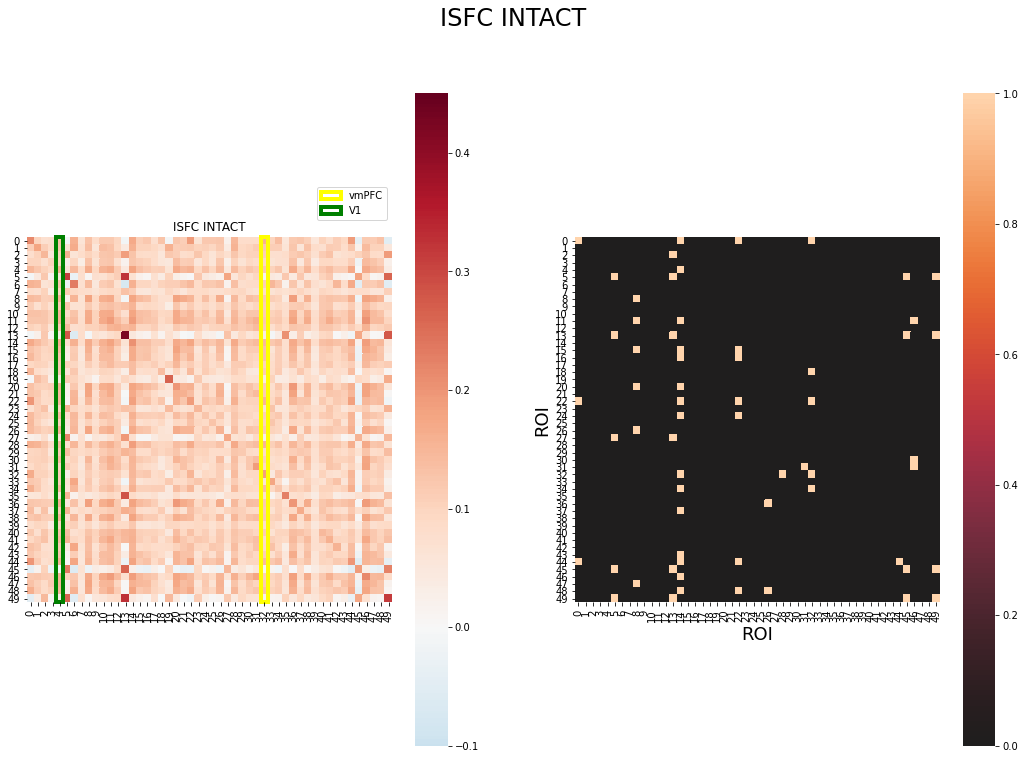

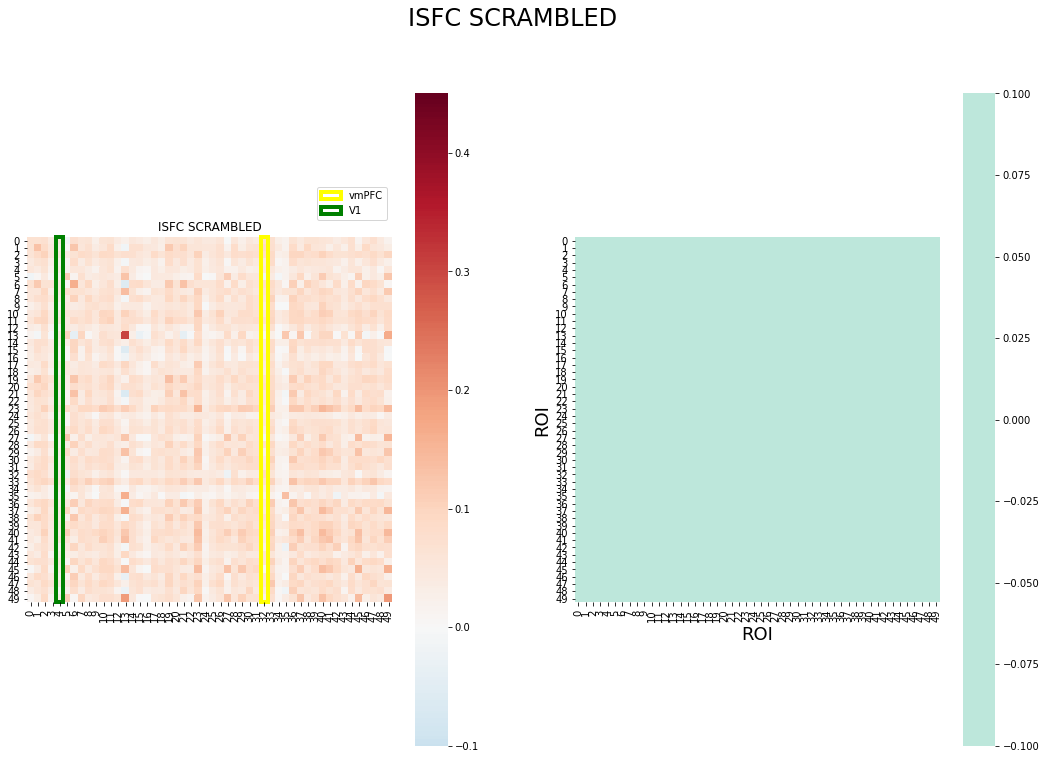

In [425]:
i_isfc_output , i_thresholded_t_pos = run_isfc(intact_subdata, "INTACT")
s_isfc_output, s_thresholded_t_pos = run_isfc(scrambled_subdata, "SCRAMBLED")

In [ ]:
# print(i_isfc_output_df.to_numpy().max())
# print(i_isfc_output_df.to_numpy().min())
# print(s_isfc_output_df.to_numpy().max())
# print(s_isfc_output_df.to_numpy().min())

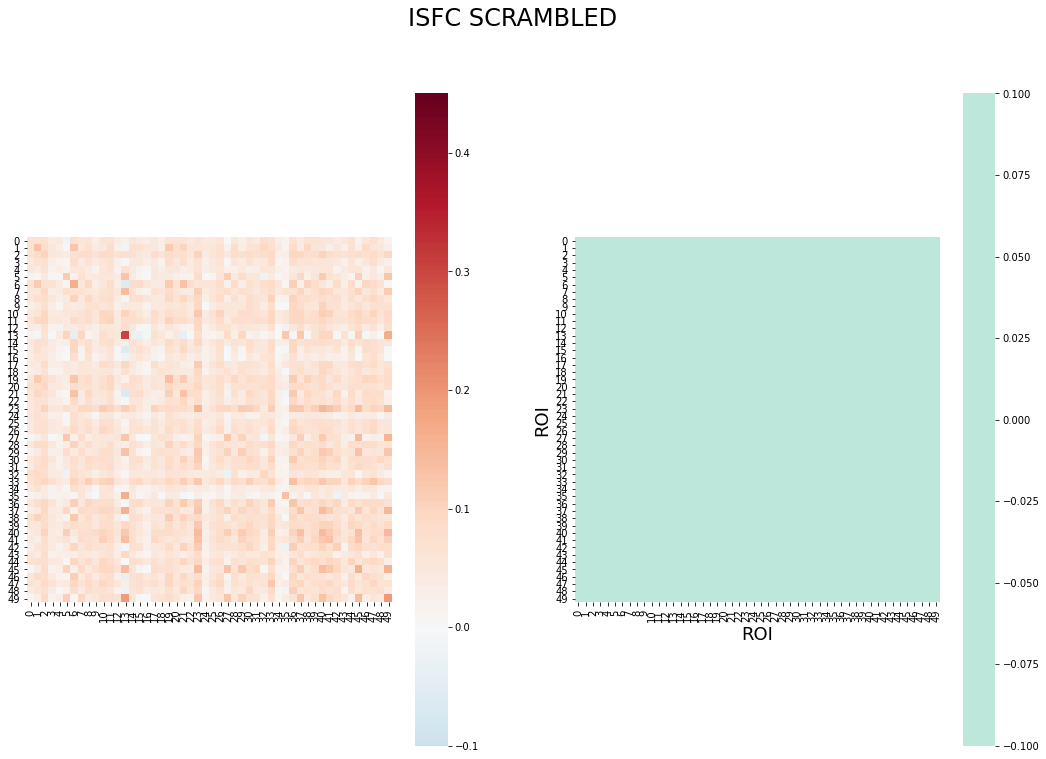

In [295]:
pd.DataFrame(data=np.array(s_isfc_output).mean(axis=0), columns=rois_df.Region.tolist())

Anterior MPFC  Fusiform/parahippocampus     DMPFC  \
0        0.068618                  0.069479  0.070026   
1        0.065154                  0.133068  0.088688   
2        0.062738                  0.086018  0.103841   
3        0.045823                  0.066923  0.073089   
4        0.053270                  0.040049  0.065845   
5       -0.014775                  0.010284  0.045927   
6        0.069695                  0.117810  0.064863   
7        0.054450                  0.056750  0.095029   
8        0.054463                  0.074672  0.080903   
9        0.025356                  0.044980  0.073677   
10       0.050242                  0.057010  0.092352   
11       0.059608                  0.093317  0.097386   
12       0.035857                  0.032948  0.073766   
13       0.015931                 -0.005493  0.061251   
14       0.046258                  0.074705  0.073628   
15       0.039114                  0.074195  0.056208   
16       0.035059                  0.059093  0.050770   
17       0.042230                  0.041212  0.086106   
18       0.032558                  0.036801  0.067806   
19       0.052168                  0.117592  0.088906   
20       0.071274                  0.084391  0.099178   
21       0.053437                  0.096153  0.077167   
22       0.047242                  0.067912  0.064495   
23       0.043462                  0.065972  0.105368   
24       0.056419                  0.069937  0.059581   
25       0.044797                  0.069446  0.071663   
26       0.050253                  0.072350  0.069870   
27      -0.005661                  0.026999  0.058136   
28       0.050105                  0.089445  0.086602   
29       0.021537                  0.036755  0.076771   
30       0.043803                  0.068296  0.088907   
31       0.035685                  0.076920  0.087234   
32       0.076690                  0.089304  0.076420   
33       0.061253                  0.086738  0.097462   
34       0.042233                  0.066175  0.041148   
35       0.022267                  0.026341  0.039060   
36       0.054210                  0.083709  0.093014   
37       0.031518                  0.041888  0.094620   
38       0.066547                  0.105562  0.088681   
39       0.054038                  0.056254  0.084984   
40       0.041493                  0.054184  0.102370   
41       0.041890                  0.029684  0.082756   
42       0.030148                  0.061129  0.070955   
43       0.056328                  0.035427  0.080861   
44       0.064417                  0.074876  0.074888   
45       0.006012                  0.036225  0.085391   
46       0.051162                  0.089045  0.075653   
47       0.065664                  0.056061  0.089925   
48       0.037400                  0.058282  0.072717   
49       0.007885                  0.034295  0.090648   

    Sensorimotor/postcentral gyrus        V1  \
0                         0.039869  0.042301   
1                         0.051892  0.029763   
2                         0.055245  0.041914   
3                         0.029637  0.022276   
4                         0.020299  0.030144   
5                         0.004182  0.008130   
6                         0.065848  0.040597   
7                         0.034106  0.040749   
8                         0.056741  0.030532   
9                         0.031100  0.011334   
10                        0.044047  0.037229   
11                        0.049832  0.052383   
12                        0.022188  0.014766   
13                       -0.004064  0.039730   
14                        0.038672  0.028647   
15                        0.039768  0.013740   
16                        0.030212  0.007611   
17                        0.035303  0.030851   
18                        0.019411  0.019489   
19                        0.067535  0.038696   
20                        0.042354  0.045380   
21                        0.060771  0.02

0.10431472756296109


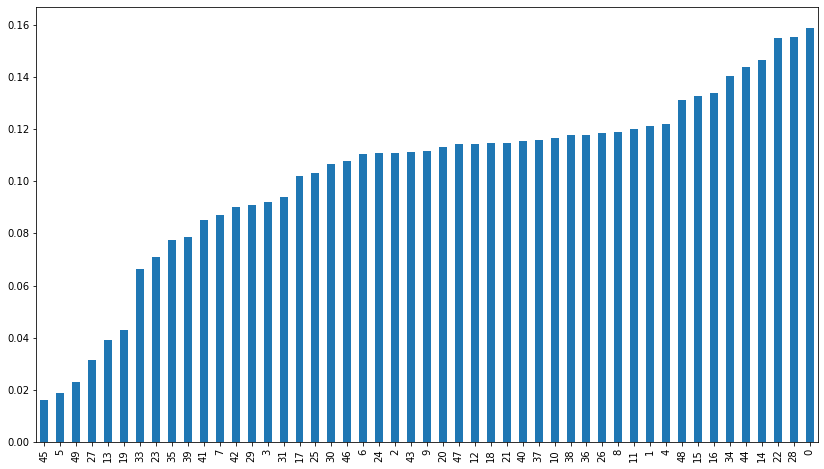

0.051817615462077214


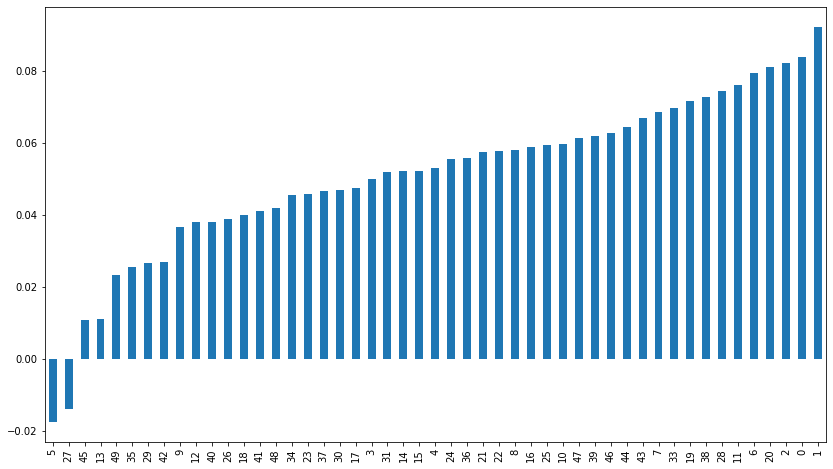

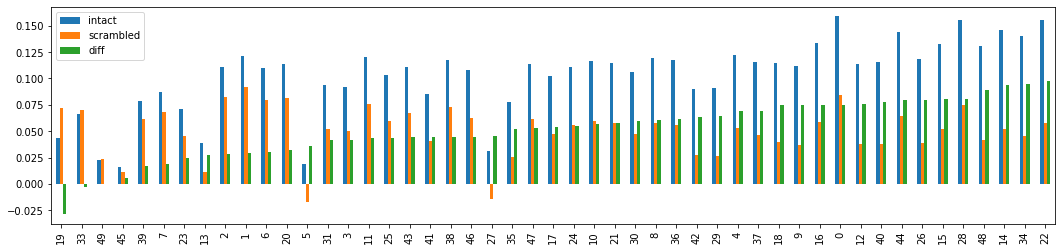

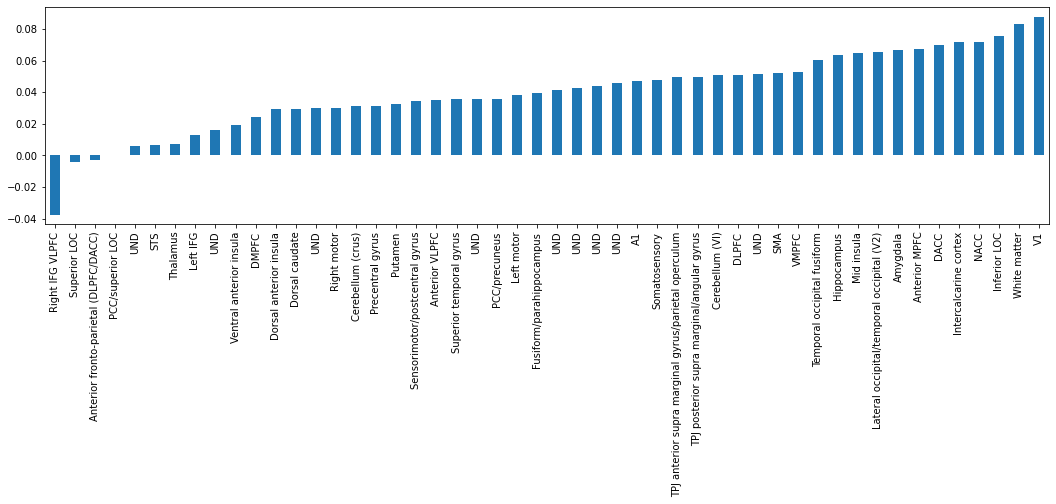

In [310]:
roi_key = "VMPFC"
roi_key_id = 32
i_isfc_output_df = pd.DataFrame(data=np.array(i_isfc_output).mean(axis=0), columns=rois_df.Region.tolist())
plt.figure(figsize=(14,8))
i_isfc_output_df[roi_key].drop(roi_key_id).sort_values().plot.bar()
i_isfc_output_df[roi_key].mean()
print(i_isfc_output_df[roi_key].mean())
plt.show()

s_isfc_output_df = pd.DataFrame(data=np.array(s_isfc_output).mean(axis=0), columns=rois_df.Region.tolist())
plt.figure(figsize=(14,8))
s_isfc_output_df[roi_key].drop(roi_key_id).sort_values().plot.bar()
print(s_isfc_output_df[roi_key].mean())
plt.show()

vmPFC_isfc_df = pd.DataFrame()
vmPFC_isfc_df["intact"] =  i_isfc_output_df[roi_key]
vmPFC_isfc_df["scrambled"] =  s_isfc_output_df[roi_key]
vmPFC_isfc_df["diff"] =  vmPFC_isfc_df["intact"] - vmPFC_isfc_df["scrambled"]
# vmPFC_isfc_df.index = rois_df.Region.tolist()
vmPFC_isfc_df.drop([roi_key_id]).sort_values(by=['diff']).plot.bar(figsize=(18,4))
plt.show()

diffs_l = i_isfc_output_df.mean() - s_isfc_output_df.mean()
diffs_l.sort_values().plot.bar(figsize=(18,4))
plt.show()
# dl = []
# for croi in rois_df.Region.tolist():
#     dl.append(i_isfc_output_df[croi].mean() - s_isfc_output_df[croi].mean())
# print(dl)
# plt.hist(dl, bins=50);
# plt.xticks(ticks = range(50) , labels = [5] * 50)
# plt.show()

In [252]:
intact_df2 = intact_df.copy()
scrambled_df2 = scrambled_df.copy()
intact_df2.columns = rois_df.Region.tolist()
scrambled_df2.columns = rois_df.Region.tolist()
scrambled_df2

Anterior MPFC  Fusiform/parahippocampus     DMPFC  \
0        -0.257772                 -0.259301 -0.485433   
1        -0.391529                 -0.116327 -0.338002   
2        -0.401728                 -0.006701 -0.381211   
3        -0.316372                  0.133934 -0.272368   
4         0.032861                  0.031599 -0.135093   
..             ...                       ...       ...   
264      -0.215184                 -0.029171 -0.139358   
265       0.000535                  0.155678  0.011008   
266      -0.013946                 -0.017793 -0.125370   
267      -0.075122                 -0.308708 -0.530800   
268      -0.264052                 -0.508887 -0.372635   

     Sensorimotor/postcentral gyrus        V1  \
0                         -0.218933  0.484844   
1                         -0.354571  0.261266   
2                         -0.470713  0.165185   
3                         -0.174565  0.244862   
4                         -0.227975  0.194464   
..                              ...       ...   
264                       -0.101242 -0.460666   
265                        0.232749 -0.097674   
266                        0.019914 -0.273259   
267                       -0.015264 -0.326925   
268                       -0.203432 -0.381281   

     TPJ posterior supra marginal/angular gyrus  PCC/precuneus  Thalamus  \
0                                     -0.545682      -0.032128 -0.153127   
1                                     -0.519644      -0.286907 -0.101068   
2                                     -0.438194      -0.232791 -0.191836   
3                                     -0.093721      -0.013655 -0.076294   
4                                      0.254850       0.283153  0.057762   
..                                          ...            ...       ...   
264                                   -0.007626      -0.116672  0.012529   
265                                    0.144438       0.152585  0.053327   
266                                    0.050331       0.021931  0.049238   
267                                   -0.112550      -0.131506 -0.057054   
268                                   -0.124487      -0.404311 -0.113084   

          SMA  Precentral gyrus  ...       UND       UND  Cerebellum (crus)  \
0   -0.461701         -0.359429  ... -0.479975  0.108364          -0.147569   
1   -0.471882         -0.233797  ... -0.574425 -0.226487          -0.311415   
2   -0.486479         -0.412216  ... -0.605514 -0.336114          -0.181847   
3   -0.111307         -0.106117  ... -0.305511 -0.196597          -0.005152   
4   -0.038278         -0.113296  ... -0.173274  0.069535           0.092300   
..        ...               ...  ...       ...       ...                ...   
264  0.172778          0.103097  ... -0.045145 -0.228687          -0.138854   
265  0.487902          0.121711  ...  0.336495  0.203526           0.475222   
266  0.183934          0.104696  ...  0.102326  0.270836           0.202993   
267 -0.032836          0.028868  ... -0.114671  0.009100           0.050476   
268 -0.176371         -0.197273  ... -0.124848 -0.256551          -0.469201   

          UND     DLPFC  Right IFG VLPFC  Inferior LOC  Right motor  \
0    0.238204 -0.102356        -0.526417     -0.308783    -0.389193   
1   -0.150225 -0.169473         0.011733     -0.104806    -0.752786   
2   -0.404731 -0.309951        -0.425166     -0.147228    -0.504139   
3   -0.118556 -0.062818        -0.175018     -0.178266    -0.069774   
4    0.023756 -0.222254        -0.191892     -0.080030    -0.048379   
..        ...       ...              ...           ...          ...   
264 -0.548775 -0.079330         0.126629     -0.190541     0.255742   
265 -0.259831  0.144808        -0.005290      0.410716     0.658872   
266 -0.364096  0.202025        -0.109753      0.432107     0.377032   
267 -0.322116 -0.097513        -0.328333      0.191744     0.018857   
268 -0.258027 -0.391463        -0.244264     -0.361599    -0.210846   

    

In [385]:
rois_df

ID                                             Region
0    0                                      Anterior MPFC
1    1                           Fusiform/parahippocampus
2    2                                              DMPFC
3    3                     Sensorimotor/postcentral gyrus
4    4                                                 V1
5    5         TPJ posterior supra marginal/angular gyrus
6    6                                      PCC/precuneus
7    7                                           Thalamus
8    8                                                SMA
9    9                                   Precentral gyrus
10  10                                    Cerebellum (VI)
11  11                        Temporal occipital fusiform
12  12                                           Amygdala
13  13                            Superior temporal gyrus
14  14                                       White matter
15  15  TPJ anterior supra marginal gyrus/parietal ope...
16  16                                         Mid insula
17  17                                            Putamen
18  18                             Dorsal anterior insula
19  19                                   PCC/superior LOC
20  20          Lateral occipital/temporal occipital (V2)
21  21                                                UND
22  22                                               DACC
23  23              Anterior fronto-parietal (DLPFC/DACC)
24  24                              Intercalcarine cortex
25  25                                     Anterior VLPFC
26  26                                         Left motor
27  27                                           Left IFG
28  28                                        Hippocampus
29  29                                     Dorsal caudate
30  30                                                UND
31  31                                                UND
32  32                                              VMPFC
33  33                                                UND
34  34                                               NACC
35  35                                                 A1
36  36                                                UND
37  37                            Ventral anterior insula
38  38                                                UND
39  39                                       Superior LOC
40  40                                                UND
41  41                                                UND
42  42                                  Cerebellum (crus)
43  43                                                UND
44  44                                              DLPFC
45  45                                    Right IFG VLPFC
46  46                                       Inferior LOC
47  47                                        Right motor
48  48                                      Somatosensory
49  49                                                STS

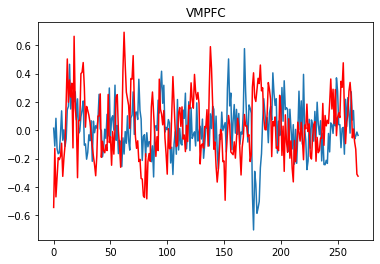

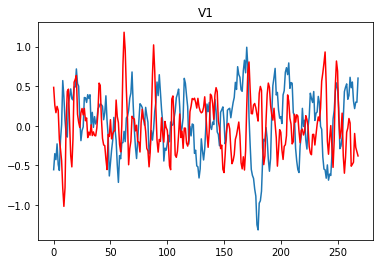

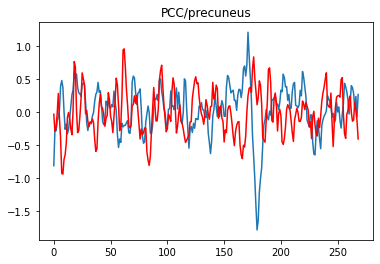

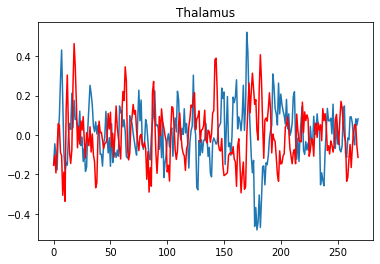

In [261]:
for a in ["VMPFC", "V1", "PCC/precuneus","Thalamus"]:
    plt.plot(intact_df2[a])
    plt.plot(scrambled_df2[a], 'r')
    plt.title(a)
    plt.show()

In [2]:
import pandas as pd
pd.read_csv("spatial_isc_res_df.csv")

df_type       cond     roi  subject_id  sentence_idx pair_type  \
0         orig     intact  reward          23             0    actual   
1         orig     intact  reward          23             0  baseline   
2         orig     intact  reward          23             0  baseline   
3         orig     intact  reward          23             0  baseline   
4         orig     intact  reward          23             0  baseline   
...        ...        ...     ...         ...           ...       ...   
855355   pca20  scrambled  vision         131            65  baseline   
855356   pca20  scrambled  vision         131            65  baseline   
855357   pca20  scrambled  vision         131            65  baseline   
855358   pca20  scrambled  vision         131            65  baseline   
855359   pca20  scrambled  vision         131            65  baseline   

         idx_pairs      corr1     pval1     corr2     pval2  
0       (nan, nan)  -0.044351  0.000001 -0.031583  0.000531  
1         (15, 49)  74.813960       NaN  0.761835       NaN  
2         (58, 45)  73.104727       NaN  1.018241       NaN  
3         (25, 56)  61.575971       NaN  0.953955       NaN  
4           (1, 2)  80.843802       NaN  0.644758       NaN  
...            ...        ...       ...       ...       ...  
855355    (51, 37)  20.837500       NaN  1.354020       NaN  
855356    (34, 41)  34.134054       NaN  1.411803       NaN  
855357    (17, 53)  27.964654       NaN  1.541312       NaN  
855358    (59, 17)  33.720006       NaN  1.061327       NaN  
855359    (29, 48)  26.854732       NaN  0.592187       NaN  

[855360 rows x 11 columns]

In [325]:
[x for x in rois_df.Region.tolist() if "nf" in x or "IPL" in x ]

['Inferior LOC']

In [20]:
msc_df = pd.read_csv("multi_sentences_classifier.csv")
msc_df

Unnamed: 0    cond  test_subj train_type                        fs  \
0              0  reward         23     actual       PCA(n_components=8)   
1              1  reward         23   shuffled       PCA(n_components=8)   
2              2  reward         23     actual       PCA(n_components=8)   
3              3  reward         23   shuffled       PCA(n_components=8)   
4              4  reward         23     actual      PCA(n_components=10)   
...          ...     ...        ...        ...                       ...   
1147        1147  vision        110   shuffled  FastICA(n_components=15)   
1148        1148  vision        110     actual  FastICA(n_components=20)   
1149        1149  vision        110   shuffled  FastICA(n_components=20)   
1150        1150  vision        110     actual  FastICA(n_components=20)   
1151        1151  vision        110   shuffled  FastICA(n_components=20)   

                                    est  accuracy  \
0                  SVC(kernel='linear')  0.045455   
1                  SVC(kernel='linear')  0.000000   
2     LogisticRegression(max_iter=1000)  0.015152   
3     LogisticRegression(max_iter=1000)  0.015152   
4                  SVC(kernel='linear')  0.075758   
...                                 ...       ...   
1147  LogisticRegression(max_iter=1000)  0.000000   
1148               SVC(kernel='linear')  0.015152   
1149               SVC(kernel='linear')  0.030303   
1150  LogisticRegression(max_iter=1000)  0.015152   
1151  LogisticRegression(max_iter=1000)  0.030303   

                                                 y_pred  \
0     ['45' '3' '46' '3' '60' '38' '8' '38' '8' '3' ...   
1     ['57' '22' '4' '22' '28' '6' '3' '6' '3' '22' ...   
2     ['45' '60' '26' '60' '3' '20' '8' '38' '8' '29...   
3     ['58' '59' '16' '59' '35' '47' '30' '2' '30' '...   
4     ['45' '3' '42' '3' '60' '38' '8' '38' '8' '3' ...   
...                                                 ...   
1147  ['48' '52' '52' '41' '29' '45' '2' '51' '2' '5...   
1148  ['21' '33' '33' '8' '9' '43' '12' '41' '12' '4...   
1149  ['5' '7' '7' '17' '64' '34' '47' '53' '47' '53...   
1150  ['63' '33' '33' '44' '57' '4' '12' '37' '12' '...   
1151  ['31' '42' '42' '57' '10' '61' '37' '15' '37' ...   

                                                 y_test  
0     ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
1     ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
2     ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
3     ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
4     ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
...                                                 ...  
1147  ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
1148  ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
1149  ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
1150  ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
1151  ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  

[1152 rows x 9 columns]

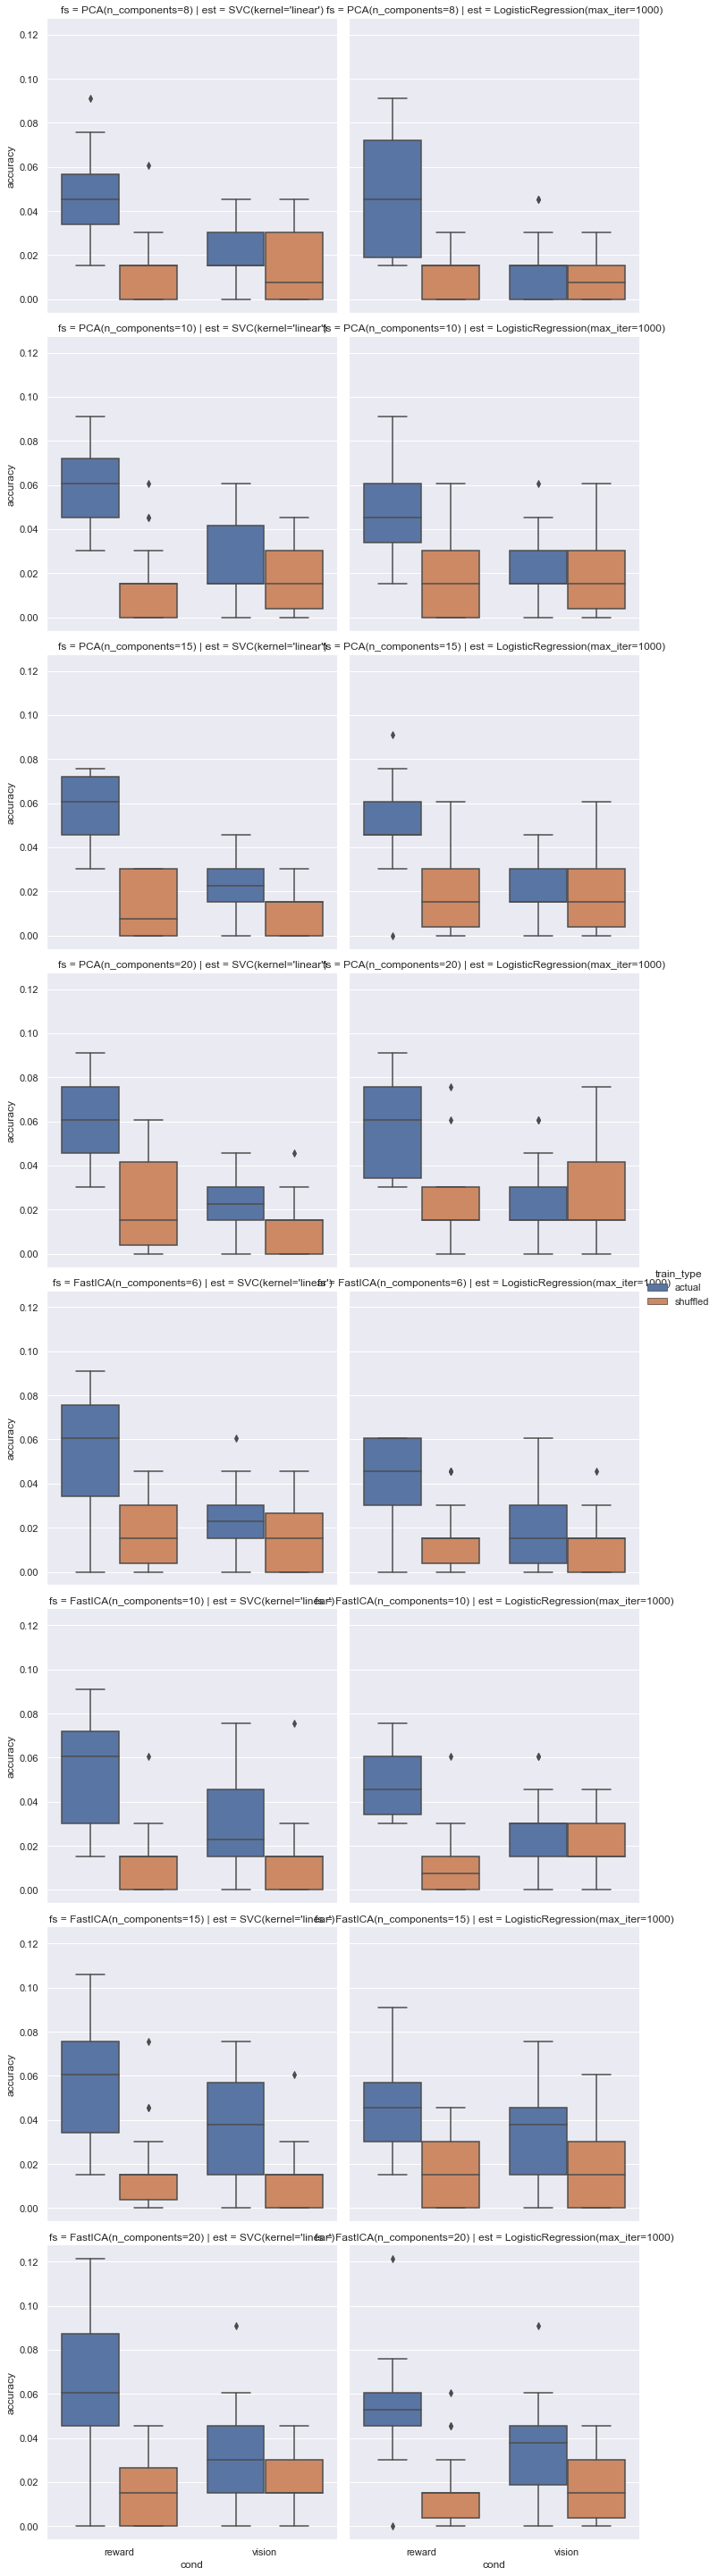

In [21]:
import seaborn as sns
sns.set(font_scale=1)
sns.catplot( data=msc_df,col='est', kind='box',row='fs',y='accuracy',x='cond', hue='train_type')

In [22]:
msc_df

Unnamed: 0    cond  test_subj train_type                        fs  \
0              0  reward         23     actual       PCA(n_components=8)   
1              1  reward         23   shuffled       PCA(n_components=8)   
2              2  reward         23     actual       PCA(n_components=8)   
3              3  reward         23   shuffled       PCA(n_components=8)   
4              4  reward         23     actual      PCA(n_components=10)   
...          ...     ...        ...        ...                       ...   
1147        1147  vision        110   shuffled  FastICA(n_components=15)   
1148        1148  vision        110     actual  FastICA(n_components=20)   
1149        1149  vision        110   shuffled  FastICA(n_components=20)   
1150        1150  vision        110     actual  FastICA(n_components=20)   
1151        1151  vision        110   shuffled  FastICA(n_components=20)   

                                    est  accuracy  \
0                  SVC(kernel='linear')  0.045455   
1                  SVC(kernel='linear')  0.000000   
2     LogisticRegression(max_iter=1000)  0.015152   
3     LogisticRegression(max_iter=1000)  0.015152   
4                  SVC(kernel='linear')  0.075758   
...                                 ...       ...   
1147  LogisticRegression(max_iter=1000)  0.000000   
1148               SVC(kernel='linear')  0.015152   
1149               SVC(kernel='linear')  0.030303   
1150  LogisticRegression(max_iter=1000)  0.015152   
1151  LogisticRegression(max_iter=1000)  0.030303   

                                                 y_pred  \
0     ['45' '3' '46' '3' '60' '38' '8' '38' '8' '3' ...   
1     ['57' '22' '4' '22' '28' '6' '3' '6' '3' '22' ...   
2     ['45' '60' '26' '60' '3' '20' '8' '38' '8' '29...   
3     ['58' '59' '16' '59' '35' '47' '30' '2' '30' '...   
4     ['45' '3' '42' '3' '60' '38' '8' '38' '8' '3' ...   
...                                                 ...   
1147  ['48' '52' '52' '41' '29' '45' '2' '51' '2' '5...   
1148  ['21' '33' '33' '8' '9' '43' '12' '41' '12' '4...   
1149  ['5' '7' '7' '17' '64' '34' '47' '53' '47' '53...   
1150  ['63' '33' '33' '44' '57' '4' '12' '37' '12' '...   
1151  ['31' '42' '42' '57' '10' '61' '37' '15' '37' ...   

                                                 y_test  
0     ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
1     ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
2     ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
3     ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
4     ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
...                                                 ...  
1147  ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
1148  ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
1149  ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
1150  ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  
1151  ['0', '1', '2', '3', '4', '5', '6', '7', '8', ...  

[1152 rows x 9 columns]